# **Diplomado IA: Audio y Video - Parte 1**. <br> Práctico 4: Reconocimiento de Voz
---
---

**Profesores:**
- Alain Raymond
- Gabriel Sepúlveda
- Álvaro Soto

**Ayudante:**
- Gabriel Molina
---
---

# **Instrucciones Generales**

El siguiente práctico se debe realizar de forma individual. El formato de entregar es el **archivo .ipynb con todas las celdas ejecutadas**. Las secciones donde se planteen preguntas de forma explícita, deben ser respondida en celdas de texto, y no se aceptará solo el _output_ de una celda de código como respuesta.

**Nombre alumno:**

El siguiente práctico cuanta con 3 secciones donde cada una contendrá 1 o más actividades a realizar. Algunas actividades correspondrán a escribir código y otras a responder preguntas. 

Antes de responder, se recomienda **fuertemente** revisar las secciones previas donde se desarrollan los ejemplos, dado que algunas de las actividades pueden ser completadas reutilizando el mismo código.

**Fecha de entrega:** lunes 24 de mayo de 2021, 23:59 hrs.

---
**IMPORTANTE:** habrá un bonus de 1 décima para todos aquellos alumnos/as que muestren buen orden en sus respuestas (esto aplica a legibilidad de código, buena redacción, formalidad, organización del jupyter notebook, seguimiento de instrucciones, etc). El criterio lo pondrá cada ayudante corrector. La nota máxima obtenible en el laboratorio es 7.0

#Preamble

In [ ]:
import sys
import os
import os.path
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!if [ ! -f torch_weights.h5 ]; then wget -q --show-progress https://www.dropbox.com/s/u4ptztlgj3n9rot/torch_weights.h5; fi
!if [ ! -f voxceleb1_veri_test.txt ]; then wget -q --show-progress https://www.dropbox.com/s/fqf0ho04eyzmrrs/voxceleb1_veri_test.txt; fi
!if [ ! -f vox1_test_wav.zip ]; then wget -q --show-progress https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip; fi
!unzip -q vox1_test_wav.zip

#Dataloader

In [ ]:
def load_wav( vid_path, sr ):
  wav, sr_ret = librosa.load( vid_path, sr=sr )
  extended_wav = np.append(wav, wav[::-1])
  return extended_wav

def lin_spectogram_from_wav( wav, hop_length, win_length, n_fft = 1024 ):
  linear = librosa.stft(wav, n_fft=n_fft, win_length=win_length, hop_length=hop_length) # linear spectrogram
  return linear.T

def load_data( path, win_length = 400, sr = 16000, hop_length = 160, n_fft = 512, spec_len = 250 ):
  wav = load_wav(path, sr=sr)
  linear_spect = lin_spectogram_from_wav(wav, hop_length, win_length, n_fft)
  mag, _ = librosa.magphase(linear_spect)  # magnitude
  mag_T = mag.T
  freq, time = mag_T.shape
  spec_mag = mag_T
  # preprocessing, subtract mean, divided by time-wise var
  mu = np.mean(spec_mag, 0, keepdims=True)
  std = np.std(spec_mag, 0, keepdims=True)
  return (spec_mag - mu) / (std + 1e-5)

#Model

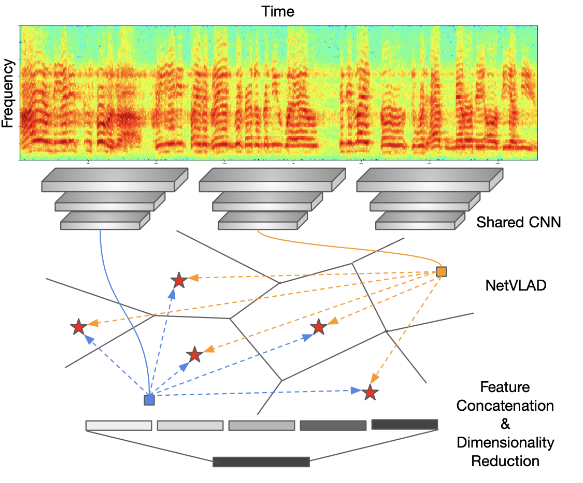

Thin Resnet

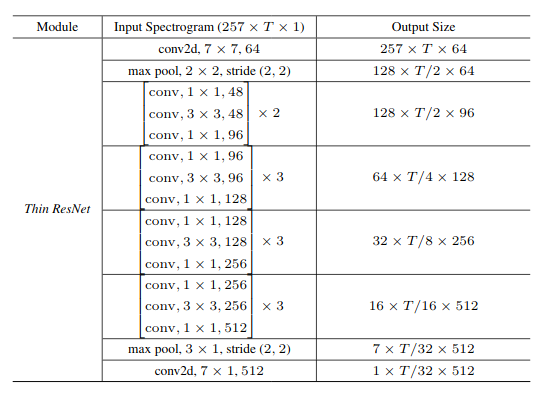

In [ ]:
class IdentityBlock2D( nn.Module ):

  def __init__( self, input_channels, kernel_size, filters ):
    super( IdentityBlock2D, self ).__init__()
    filters1, filters2, filters3 = filters
    self.branch1 = nn.Sequential(
        nn.Conv2d( input_channels, filters1, (1, 1), bias = False ),
        nn.BatchNorm2d( filters1 ),
        nn.ReLU(),
        nn.Conv2d( filters1, filters2, kernel_size, padding = (1, 1), bias = False ),
        nn.BatchNorm2d( filters2 ),
        nn.ReLU(),
        nn.Conv2d( filters2, filters3, (1, 1), bias = False ),
        nn.BatchNorm2d( filters3 )
    )
    self.relu = nn.ReLU()

  def forward( self, x ):
    x = self.branch1( x ) + x
    x = self.relu( x )
    return x

class ConvBlock2D( nn.Module ):

  def __init__( self, input_channels, kernel_size, filters, strides = (2, 2) ):
    super( ConvBlock2D, self ).__init__()
    filters1, filters2, filters3 = filters
    self.branch1 = nn.Sequential(
        nn.Conv2d( input_channels, filters1, (1, 1), stride = strides, bias = False ),
        nn.BatchNorm2d( filters1 ),
        nn.ReLU(),
        nn.Conv2d( filters1, filters2, kernel_size, padding = (1, 1), bias = False ),
        nn.BatchNorm2d( filters2 ),
        nn.ReLU(),
        nn.Conv2d( filters2, filters3, (1, 1), bias = False ),
        nn.BatchNorm2d( filters3 )
    )
    self.branch2 = nn.Sequential(
        nn.Conv2d( input_channels, filters3, (1, 1), stride = strides, bias = False ),
        nn.BatchNorm2d( filters3 ),
    )
    self.relu = nn.ReLU()

  def forward( self, x ):
    x1 = self.branch1( x )
    x2 = self.branch2( x )
    x = x1 + x2
    x = self.relu( x )
    return x

class ThinResNet( nn.Module ):

  def __init__( self ):
    super( ThinResNet, self ).__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d( 1, 64, (7, 7), stride = (1, 1), bias = False, padding = 3 ), # padding='same'
        nn.BatchNorm2d( 64 ),
        nn.ReLU(),
        nn.MaxPool2d( (2, 2), stride = (2, 2) )
    )
    self.block2 = nn.Sequential(
        ConvBlock2D( 64, 3, [48, 48, 96], strides=(1, 1) ),
        IdentityBlock2D( 96, 3, [48, 48, 96] )
    )
    self.block3 = nn.Sequential(
        ConvBlock2D( 96, 3, [96, 96, 128] ),
        IdentityBlock2D( 128, 3, [96, 96, 128] ),
        IdentityBlock2D( 128, 3, [96, 96, 128] )
    )
    self.block4 = nn.Sequential(
        ConvBlock2D( 128, 3, [128, 128, 256] ),
        IdentityBlock2D( 256, 3, [128, 128, 256] ),
        IdentityBlock2D( 256, 3, [128, 128, 256] )
    )
    self.block5 = nn.Sequential(
        ConvBlock2D( 256, 3, [256, 256, 512] ),
        IdentityBlock2D( 512, 3, [256, 256, 512] ),
        IdentityBlock2D( 512, 3, [256, 256, 512] )
    )
    self.max_pool = nn.MaxPool2d( (3, 1), stride = (2, 1) )

  def forward( self, x ):
    x = self.block1( x )
    x = self.block2( x )
    x = self.block3( x )
    x = self.block4( x )
    x = self.block5( x )
    x = self.max_pool( x )
    return x

In [ ]:
class VladPooling( nn.Module ):

  def __init__( self, k_centers, d_size ):
    super( VladPooling, self ).__init__()
    self.k_centers = k_centers
    self.g_centers = 2
    self.cluster = nn.Parameter( torch.Tensor( self.k_centers + self.g_centers, d_size ) )
    torch.nn.init.xavier_uniform_( self.cluster )

  def forward( self, feat, cluster_score ):
    # feat : bz x W x H x D
    # cluster_score: bz x W x H x clusters.
    feat = feat.permute( 0, 2, 3, 1 )
    cluster_score = cluster_score.permute( 0, 2, 3, 1 )
    num_features = feat.shape[-1]

    # softmax normalization to get soft-assignment.
    # A : bz x W x H x clusters
    max_cluster_score, _ = cluster_score.max( dim = -1, keepdim = True )
    exp_cluster_score = torch.exp( cluster_score - max_cluster_score )
    A = exp_cluster_score / exp_cluster_score.sum( dim = -1, keepdim = True )

    # Now, need to compute the residual, self.cluster: clusters x D
    A = A.unsqueeze( dim = -1 )                 # A : bz x W x H x clusters x 1
    feat_broadcast = feat.unsqueeze( dim = -2 ) # feat_broadcast : bz x W x H x 1 x D
    feat_res = feat_broadcast - self.cluster    # feat_res : bz x W x H x clusters x D
    weighted_res = torch.mul( A, feat_res )     # weighted_res : bz x W x H x clusters x D
    cluster_res = weighted_res.sum( dim = [1, 2] )
    cluster_res = cluster_res[:, :self.k_centers, :]

    cluster_l2 = F.normalize( cluster_res, dim = -1, p = 2 )
    outputs = cluster_l2.view( [-1, int(self.k_centers) * int(num_features)] )
    return outputs

In [ ]:
class NetVlad( nn.Module ):

  def __init__( self ):
    super( NetVlad, self ).__init__()
    self.vlad_clusters = 8
    self.ghost_clusters = 2
    self.bottleneck_dim = 512
    self.num_class = 8631

    self.thin_resnet = ThinResNet()
    self.vlad_pooling = VladPooling( self.vlad_clusters, self.bottleneck_dim )
    self.block_1 = nn.Conv2d( self.bottleneck_dim, self.bottleneck_dim, (7, 1), stride = (1, 1), bias = True )
    self.block_1_activation = nn.ReLU()
    self.vlad_conv = nn.Conv2d( self.bottleneck_dim, self.vlad_clusters + self.ghost_clusters, (7, 1), stride = (1, 1), bias = True )
    self.block_2 = nn.Linear( self.vlad_clusters*self.bottleneck_dim, self.bottleneck_dim )
    self.block_2_activation = nn.ReLU()
    self.dense_1 = nn.Linear( self.bottleneck_dim, self.num_class, bias = False )
    self.dense_1_activation = nn.Softmax( dim = -1 )

  def forward( self, x ):
    x = self.thin_resnet( x )                           # output: 7 x T/32 x 512
    x_fc = self.block_1_activation( self.block_1( x ) ) # output: 1 x T/32 x 512
    x_k_center = self.vlad_conv( x )                    # output: 1 x T/32 x 10 (score)
    x = self.vlad_pooling( x_fc, x_k_center )
    x = self.block_2_activation( self.block_2( x ) )
    x = F.normalize( x, dim = 1, p = 2 )
    return x

#Evaluación

##Explorando archivo de metadata del test set

In [ ]:
!head voxceleb1_veri_test.txt

##Extracción de features

In [ ]:
data_path = 'wav'
metadata_file = 'voxceleb1_veri_test.txt'

verify_list = np.loadtxt( metadata_file, str )

verify_lb = np.array([int(i[0]) for i in verify_list])
list1 = np.array([os.path.join(data_path, i[1]) for i in verify_list])
list2 = np.array([os.path.join(data_path, i[2]) for i in verify_list])

total_list = np.concatenate((list1, list2))
unique_list = np.unique(total_list)

In [ ]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )
print( 'running on: %s' % (device) )

network_eval = NetVlad()

weights_file = 'torch_weights.h5'
if os.path.isfile( weights_file ):
    print( 'loading weights from file [%s]' % (weights_file) )
    network_eval.load_state_dict( torch.load( weights_file, map_location = device ) )
network_eval = network_eval.to( device )

In [ ]:
network_eval.eval()
with torch.no_grad():
  total_length = len(unique_list)
  feats = list()
  for c, ID in enumerate(unique_list):
    if c % 50 == 0: print('Finish extracting features for {}/{}th wav.'.format(c, total_length))
    specs = load_data(ID, win_length=400, sr=16000, hop_length=160, n_fft=512, spec_len=250)
    specs = torch.from_numpy( specs )
    specs = specs.to( device )
    specs = specs.unsqueeze( 0 ).unsqueeze( 0 ) # batch_dim, channel_dim

    v = network_eval( specs )
    feats += [v.cpu().numpy()]

  feats = np.stack( feats )

##Definición de umbral de clasificación a través de curva ROC

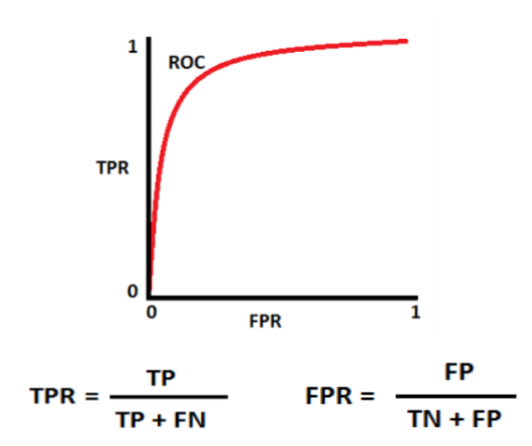

In [ ]:
def calculate_eer(y, y_score):
  # y denotes groundtruth scores,
  # y_score denotes the prediction scores.
  from scipy.optimize import brentq
  from sklearn.metrics import roc_curve
  from scipy.interpolate import interp1d
  fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=1)
  eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
  thresh = interp1d(fpr, thresholds)(eer)
  return eer, thresh

##Evaluación de audios a través del cálculo de score

In [ ]:
# ==> compute the pair-wise similarity.
scores = list()
labels = list()
for c, (p1, p2) in enumerate(zip(list1, list2)):
    ind1 = np.where(unique_list == p1)[0][0]
    ind2 = np.where(unique_list == p2)[0][0]

    v1 = feats[ind1, 0]
    v2 = feats[ind2, 0]

    scores += [np.sum(v1*v2)]
    labels += [verify_lb[c]]
    print('scores : {}, gt : {}'.format(scores[-1], verify_lb[c]))

scores = np.array(scores)
labels = np.array(labels)

eer, thresh = calculate_eer(labels, scores)
print('==> model : {}, threshold: {}, EER: {}'.format(weights_file, thresh, eer))

#Actividades

##Actividad 1

¿ Cuál es la principal desventaja de usar un modelo de clasificación para la tarea de reconocimiento de hablante ?

In [ ]:
#@title Respuesta 1

Respuesta = 'seleccione una opcion' #@param ["seleccione una opcion", "El etiquetado de los datos es extremadamente costoso","Existirán tantas clases como personas, lo que implica una altísima dimensionalidad de salida","Cada vez que agreguemos una nueva persona, tendremos que reentrenar el modelo","Los modelos de clasificación no tienen buen rendimiento en este tipo de tareas", "Los modelos de clasificación no tienen ninguna desventaja con respecto al visto en clases"]


##Actividad 2

¿ Por qué se obtienen N descriptores por cada señal de audio en el procesamiento de VLAD ?

In [ ]:
#@title Respuesta 1

Respuesta = 'seleccione una opcion' #@param ["seleccione una opcion", "Porque debemos generar tantos descriptores como centroides","Porque necesitamos separar las frecuencias en slots temporales","Para mantener un tamaño de descriptores relativamente bajo, pero sin perder demasiada información", "Porque sirve para mantener información de la ubicación (localidad) desde donde cada descriptor fue extraído"]


##Actividad 3

¿ Cómo se adapta la función de pertenencia $a_{k}(x_{i})$ para poder ser aprendida end-to-end ?

In [ ]:
#@title Respuesta 1

Respuesta = 'seleccione una opcion' #@param ["seleccione una opcion", "Se convierte en una red neuronal con una función softmax a la salida", "Se convierte en una red neuronal con una función sigmoidal a la salida","Se convierte en una función que permite obtener la diferencia entre cada descriptor y el centroide más cercano","No se utiliza ya que se considera que cada vector pertenece a todos los centroides", "No sufre alteraciones con respecto a la definición original"]
